In [1]:
import netCDF4 as nc
import scipy 
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import dask
from xmhw.xmhw import threshold, detect
from datetime import date
import cftime
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit
import plotly.express as px
import plotly.graph_objects as go
import hashlib
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import glob
import math
import seaborn as sns
from cmcrameri import cm
import matplotlib.ticker as mticker
import warnings

In [2]:
from scipy.spatial import cKDTree
from timeit import default_timer as timer
def find_nearest_ocean_cell(lat, lon, dataset):
    """
    Improved method to find the nearest ocean cell for a given latitude and longitude using a KDTree for spatial search.
    
    Args:
    - lat (float): Latitude of the land coordinate.
    - lon (float): Longitude of the land coordinate.
    - dataset (xarray.Dataset): The dataset containing SST data.
    
    Returns:
    - (float, float): Latitude and longitude of the nearest ocean cell with valid SST data,
                      or (None, None) if no valid ocean cell is found.
    """
    # Ensure longitude is in the same format as the dataset
    if lon < 0:
        lon += 360
    
    # Flatten the lat/lon coordinates and create a KDTree for spatial search
    lats = dataset['lat'].values
    lons = dataset['lon'].values
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    valid_mask = np.isfinite(dataset['sst'].isel(time=0).values.ravel())  # Check first time and level
    valid_points = np.vstack([lat_grid.ravel()[valid_mask], lon_grid.ravel()[valid_mask]]).T
    tree = cKDTree(valid_points)

    # Find the nearest valid (ocean) cell
    distance, location = tree.query([lat, lon], k=1)  # k=1 for the nearest neighbor
    nearest_lat, nearest_lon = valid_points[location]

    return nearest_lat, nearest_lon

In [3]:
urchin_3d = pd.read_csv('3de_cr_ea_site.csv')

ku_concat_mhw = pd.read_csv('all_urchin_kelp_mhw.csv')
ku_concat_mhw = ku_concat_mhw[ku_concat_mhw.longitude > 140].reset_index(drop = True)
urchin_3d = urchin_3d[urchin_3d.site_name.isin(ku_concat_mhw.site_name)].reset_index(drop=True)
urchin_3d = urchin_3d[['location', 'site_name', 'latitude', 'longitude', 'number']]

In [4]:
source = ''  ## path of CMIP6 summer sst
filenames = sorted(glob.glob(source + 'summerdailysst*585*.nc'))
filenames

['/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.BCC-CSM2-MR.historical+ssp585.r1i1p1f1.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.CNRM-CM6-1-HR.historical+ssp585.r1i1p1f2.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.CNRM-ESM2-1.historical+ssp585.r1i1p1f2.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.CanESM5.historical+ssp585.r1i1p1f1.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.EC-Earth3-Veg-LR.historical+ssp585.r1i1p1f1.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.EC-Earth3-Veg.historical+ssp585.r1i1p1f1.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.EC-Earth3.historical+ssp585.r11i1p1f1.nc',
 '/g/data/ng72/js5018/chapter3/modelling/cmip_hf/summerdailysst.GFDL-ESM4.historical+ssp585.r1i1p1f1.nc']

In [5]:
for i in np.arange(0, 8):
    dsi = xr.open_dataset(filenames[i])
    
    if 'i' in dsi.dims:
        dsi = dsi.assign_coords({'i': dsi.lon.isel(j=0), 'j': dsi.lat.isel(i=0)}).drop_vars(['lon','lat']).rename({'i':'lon','j':'lat'})
    elif 'x' in dsi.dims:
        dsi = dsi.assign_coords({'x': dsi.lon.isel(y=0), 'y': dsi.lat.isel(x=0)}).drop_vars(['lon','lat']).rename({'x':'lon','y':'lat'})

    if np.isnan(dsi['sst'].values).all():
        break
        print('Cmip output ', i, ' is empty')
    ds = dsi.copy()
    
    if type(ds.time.values[0]) is cftime.DatetimeNoLeap: 
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="Converting a CFTimeIndex.*")
            ds['time'] = ds.indexes['time'].to_datetimeindex()
            
    # silence the no calendar warning
    if 'calendar' not in ds.time.encoding:
        ds.time.encoding['calendar'] = 'noleap'  # or 'standard'
            
    print('calculating MHW metrics over decades for model ', i, '...')
    df_climatmax_timeseries = pd.DataFrame([])
    start_year = 2020
    end_year = 2100
    decades = list(range(start_year, end_year, 10))

    for i, row in urchin_3d.iterrows():
        location = row['location']
        site_name = row['site_name']
        lat = row['latitude']
        lon = row['longitude']

        # select specific location
        
        ds_locat = ds.sel(lat = lat, lon = lon, method='nearest')#.squeeze('zlev', drop=True)
        # Skip this iteration if the data is all NaNs
        if ds_locat.sst.isnull().all():     
            nearest_lat, nearest_lon = find_nearest_ocean_cell(lat, lon, ds)

            if nearest_lat is not None and nearest_lon is not None:
                ds_locat = ds.sel(lat = nearest_lat, lon = nearest_lon)#.squeeze('zlev', drop=True) 
            else:
                print(f"No valid ocean cell found for: {location}")
                continue  # Skip this location
            
        clim = threshold(ds_locat.sst, pctile = 90, climatologyPeriod=[1991, 2020]) # threshold and climatology
        maxclim = float(clim.seas.max().values)  # Convert to float
        # maxthresh = float(clim.thresh.max().values)
        # thresh90 = clim.thresh.where((clim.doy < 122) | (clim.doy > 335), drop=True).mean().values
        # seasonal50 = clim.seas.where((clim.doy < 122) | (clim.doy > 335), drop=True).mean().values

        # print('looping decades of sst/imax calculation...')
        for decade1 in decades:
            decade2 = decade1 + 10

            # Define summer period for that decade
            summer_start = f'{decade1 - 1}-12-01'  # e.g. 2029-12-01
            summer_end = f'{decade2}-04-30'        # e.g. 2030-04-30

            ds_summer = ds_locat.sel(time=slice(summer_start, summer_end))

            summer_temp = ds_summer.sst.mean(dim='time').values
            max_inten = (ds_summer.sst - maxclim).max().values

            df_var = pd.DataFrame({'model': i,
                                   'location': [location],
                                   'site_name': [site_name],
                                   'latitude': [lat],
                                   'longitude': [lon],
                                   'decade': [f'{decade1}s'],
                                   'summer_temp': [summer_temp],
                                   'max_inten': [max_inten]})

            df_climatmax_timeseries = pd.concat([df_climatmax_timeseries, df_var], ignore_index=True)
df_climatmax_timeseries

0.3.0
calculating MHW metrics over decades for model  0 ...
calculating MHW metrics over decades for model  1 ...
calculating MHW metrics over decades for model  2 ...
calculating MHW metrics over decades for model  3 ...
calculating MHW metrics over decades for model  4 ...
calculating MHW metrics over decades for model  5 ...
calculating MHW metrics over decades for model  6 ...
calculating MHW metrics over decades for model  7 ...


,model,location,site_name,latitude,longitude,decade,summer_temp,max_inten
0,0,Batemans,Acron Ledge,-35.72030,150.24789,2020s,22.90285,2.9472389221191406
1,0,Batemans,Acron Ledge,-35.72030,150.24789,2030s,23.00967,2.4080047607421875
2,0,Batemans,Acron Ledge,-35.72030,150.24789,2040s,23.48518,2.7168426513671875
3,0,Batemans,Acron Ledge,-35.72030,150.24789,2050s,23.880215,3.426959991455078
4,0,Batemans,Acron Ledge,-35.72030,150.24789,2060s,24.362574,3.441802978515625
...,...,...,...,...,...,...,...,...
987,123,Maria Island,Spring Beach,-42.58359,147.91566,2050s,18.67154,4.83900260925293
988,123,Maria Island,Spring Beach,-42.58359,147.91566,2060s,18.919506,4.4668121337890625
989,123,Maria Island,Spring Beach,-42.58359,147.91566,2070s,19.67434,5.640205383300781
990,123,Maria Island,Spring Beach,-42.58359,147.91566,2080s,20.123203,7.275539398193359


In [6]:
df_climatmax_timeseries['summer_temp'] = df_climatmax_timeseries['summer_temp'].astype(float)
df_climatmax_timeseries['max_inten'] = df_climatmax_timeseries['max_inten'].astype(float)
print(df_climatmax_timeseries['summer_temp'].dtype)

float64


In [ ]:
df_timeseries_modelmean = df_climatmax_timeseries.groupby(['location', 'decade'])[['latitude','summer_temp', 'max_inten']].mean().reset_index()
# df_timeseries_modelmean

In [8]:
df_climatmax_timeseries.to_csv('model_input_to2090s_sitelevel_585.csv', index = False)
# df_climatmax_timeseries = pd.read_csv('/g/data/ng72/js5018/chapter3/modelling/model_input_to2090s_sitelevel_585.csv')

In [9]:
location_order = df_timeseries_modelmean.sort_values(by='latitude', ascending = False)['location'].drop_duplicates().tolist()
location_order

['Jervis Bay', 'Batemans', 'Kent Group', 'Bicheno', 'Maria Island']

/jobfs/142774602.gadi-pbs/ipykernel_3684003/2042255298.py:4: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(data=df_timeseries_modelmean, x='decade', y='summer_temp', hue='location',
/jobfs/142774602.gadi-pbs/ipykernel_3684003/2042255298.py:12: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=df_timeseries_modelmean, x='decade', y='max_inten', hue='location',


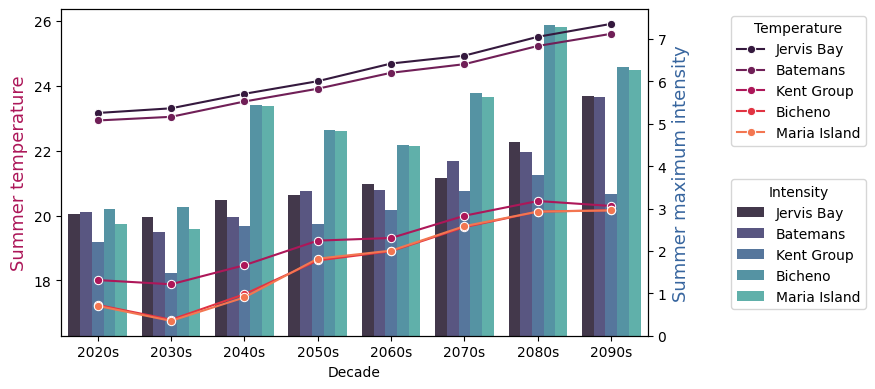

In [35]:
fig, ax1 = plt.subplots(figsize=(9, 4))

palette1 = sns.color_palette("rocket", 6)
sns.lineplot(data=df_timeseries_modelmean, x='decade', y='summer_temp', hue='location', 
             marker='o', palette=palette1, ax=ax1, hue_order=location_order)
ax1.legend(title='Temperature', loc='upper left', bbox_to_anchor=(1.13, 1))
ax1.set_zorder(2)
ax1.set_facecolor('none')

ax2 = ax1.twinx()
palette2 = sns.color_palette("mako", 6)
sns.barplot(data=df_timeseries_modelmean, x='decade', y='max_inten', hue='location', 
            palette=palette2, ax=ax2, hue_order=location_order, alpha = 0.9)
ax2.legend(title='Intensity', loc='upper left', bbox_to_anchor=(1.13, 0.5))
ax2.set_zorder(1)

# plt.title('Summer Temperature by Decade for Each Location')
ax1.set_ylabel('Summer temperature', color=palette1[2], fontsize = 13)
ax2.set_ylabel('Summer maximum intensity', color=palette2[2], fontsize = 13)
ax1.set_xlabel('Decade')
# plt.xticks(rotation=45)
# fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Moves legend outside if many locations
fig.tight_layout()


#### Add Urchin projection data from Davis et al. 2023

In [51]:
df_input = pd.read_csv('glm_input2023.csv')
df_input_new = df_input.copy()
# df_input_new['max_inten'] = df_input_new['site_name'].map(df_climatmax_timeseries[df_climatmax_timeseries.decade == '2090s'].set_index('site_name')['max_inten'])

df_input_new

,location,site_name,latitude,longitude,number,max_inten
0,Batemans,Acron Ledge,-35.72030,150.24789,0.715000,2.293980
1,Batemans,Barren Bommie,-36.13559,150.12916,2.630000,2.645718
2,Batemans,Belowla Island South West,-35.55425,150.38896,3.520000,2.293980
3,Batemans,Bingi Bingi Point,-36.01291,150.16603,0.160000,2.645718
4,Batemans,Bingi Bingi Point Nth,-36.01152,150.16517,0.030000,2.645718
...,...,...,...,...,...,...
119,Maria Island,Painted Cliffs,-42.59211,148.05035,0.023333,1.290152
120,Maria Island,Painted Cliffs South (Four Mile Reef),-42.60250,148.04628,0.042381,1.290152
121,Maria Island,Point Holme Lookout,-42.55305,147.94814,0.069074,1.290152
122,Maria Island,Return Point,-42.62899,148.02431,0.020000,1.290152


In [52]:
df_urchin_proj_davis = pd.read_csv('Davis-urchin-predictions-2090-2100.csv')
df_urchin_proj_davis.head()

,X,Name,latitude,longitude,Urchins/m^2 (1990-2000),Urchins/m^2 (2010-2020),urchin2090
0,1,pin_129,-27.0,153.416672,0.015011,0.004849,6.160000e-09
1,2,pin_123,-27.5,153.583328,0.133192,0.037544,1.940000e-07
2,3,pin_117,-28.0,153.416672,0.976536,0.369056,1.490000e-06
3,4,pin_4,-28.5,153.583328,2.425686,0.873593,4.420000e-06
4,5,pin_10,-29.0,153.500000,3.466122,1.400534,1.760000e-05


In [53]:
coords_df1 = df_input_new[['latitude', 'longitude']].to_numpy()
coords_df2 = df_urchin_proj_davis[['latitude', 'longitude']].to_numpy()

# Build spatial tree from df2
tree = cKDTree(coords_df2)
# Query closest point in df2 for each point in df1
distances, indices = tree.query(coords_df1, k=1)
# Extract corresponding urchin values from df2 using the matched indices
urchin_data = df_urchin_proj_davis.iloc[indices].reset_index(drop=True)

# Optionally include distance to nearest match
df_input_new['nearest_dist_deg'] = distances  # great-circle not used, so this is in degree units
df_input_new['number'] = urchin_data['urchin2090'].values
df_input_new

,location,site_name,latitude,longitude,number,max_inten,nearest_dist_deg
0,Batemans,Acron Ledge,-35.72030,150.24789,1.108325,2.293980,0.277524
1,Batemans,Barren Bommie,-36.13559,150.12916,2.222246,2.645718,0.140683
2,Batemans,Belowla Island South West,-35.55425,150.38896,1.108325,2.293980,0.060918
3,Batemans,Bingi Bingi Point,-36.01291,150.16603,2.222246,2.645718,0.012926
4,Batemans,Bingi Bingi Point Nth,-36.01152,150.16517,2.222246,2.645718,0.011618
...,...,...,...,...,...,...,...
119,Maria Island,Painted Cliffs,-42.59211,148.05035,2.993426,1.290152,0.097836
120,Maria Island,Painted Cliffs South (Four Mile Reef),-42.60250,148.04628,2.993426,1.290152,0.108990
121,Maria Island,Point Holme Lookout,-42.55305,147.94814,2.993426,1.290152,0.145224
122,Maria Island,Return Point,-42.62899,148.02431,2.993426,1.290152,0.141850


In [55]:
df_input_new.to_csv('glm_input_n_2090s_585.csv', index = False)